Work based on and includes excerpts from https://github.com/scotthlee/fairness

Binary implementation based on work by Hardt, Srebro, & Price (2016):
https://arxiv.org/pdf/1610.02413.pdf
"""

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sbn

from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

from CS7140_balancers import BinaryBalancer

## Working with a binary predictor
### Checking for bias
First, let's load our data. Here we're using data from CS7140 fairness model, where A = race_Black.


In [2]:
df = pd.read_csv('Data/export_dataframe.csv')
df.head()
y=df.y_true
y_=df.y_pred
a=df.A

pb = BinaryBalancer(y=y, y_=y_, a=a, summary=False)

### Adjusting biased predictions
Let's use the `.adjust()` method to see if we can achieve the same `fpr` and `tpr` (AKA equalized odds) across groups.

In [3]:
pb.adjust(goal='odds', summary=False)

`.adjust()` returns the theoretical optima for loss (1 - accuracy, in this case) and the ROC coordinates after adjustment.


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0972 0.6075
   1.0 0.0670 0.5914

Post-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0965 0.6049
   1.0 0.0942 0.6237

Calibration: 

                              0         1
Fraction where Y_ = 1  0.226100  0.128500
Fraction where Y* = 1  0.224900  0.156200
Fraction where Y = 1   0.252484  0.117128



Loss: 

           0         1   overall
Y_  0.171771  0.107053  0.165459
Y*  0.171907  0.127204  0.167547




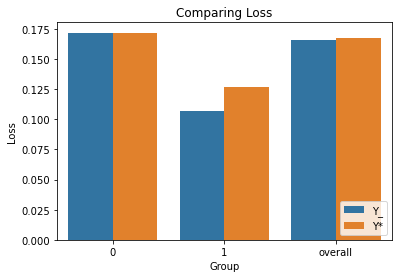

In [4]:
pb.summary(org=True,adj=True)

Notice that the predicted rates are a bit different from the theoretical optima returned by `.adjust()`. The variability here comes from the `fpr` and `tpr` of the original predictor--the adjusted predictions come from randomly picking which of those original predictions to set to `1`, but since not all of those are perfect, we get a different blend of correct guesses each time, hence the movement in the realized rates. Despite this variability, the long-run averages for the rates will be the same, though, which is the best we can do with an oblivious predictor.

### Visualizing the predictions and the adjustments
The balancer's `.plot()` function shows all of this data in action.

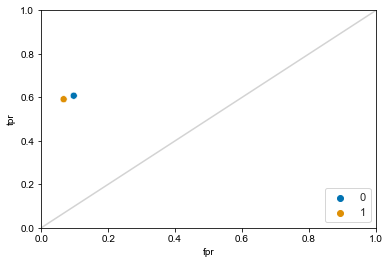

In [5]:
pb.plot(optimum=False, lp_lines=False)

Here we see the original three points in ROC space. The difference in `tpr` between all 2 groups is apparent.


If `.adjust()` has been called, `.plot()` will plot the optimum point by default. In this case, the coordiante for the worst-performing group is achievable by adjusting for the others, and so that becomes the optimum for everyone.

opt coords  0.0967   0.6044


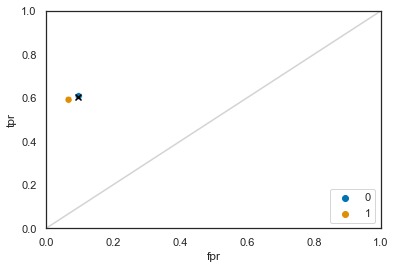

In [6]:
pb.plot(lp_lines=False)

Finally, we can plot the convex hulls showing *all* of the achievable ROC points for each group. The intersection of the hulls are rates we can achieve for all groups at once, and the point in the intersection with the lowest loss (generally closest to the top left corner of the plot) is what the linear program in `.adjust()` picks as the optimum.

opt coords  0.0967   0.6044


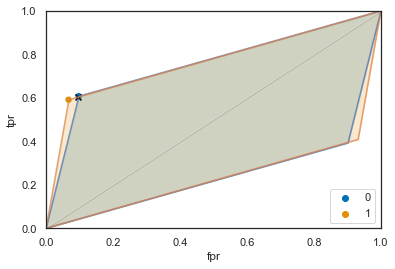

In [7]:
pb.plot()

## Working with a real-valued predictor

The `PredictionBalancer` can also handle real-valued predictors (non-probabilistic scores are normalized to be betwee 0 and 1).

In [8]:
df = pd.read_csv('Data/gender_synthetic_ROC.csv')
print(df.head())

y=df.default 
y_=df.default_pred 
a=df.gender

pb_roc = BinaryBalancer(y=y, y_=y_, a=a, summary=False)

   gender   action pred_action  default  default_pred
0  female  default     default        1          0.88
1  female  default     default        1          0.87
2  female  default     default        1          0.86
3  female  default     default        1          0.85
4  female  default     default        1          0.84
Probabilities detected.




Calibration: 

                         female      male
Fraction where Y_ = 1  0.590000  0.355700
Fraction where Y* = 1  0.453300  0.355700
Fraction where Y = 1   0.693333  0.394286



Loss: 

      female      male  overall
Y_  0.103333  0.307143    0.246
Y*  0.380000  0.307143    0.329




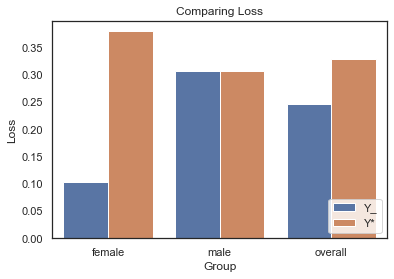

In [9]:
pb_roc.adjust(goal='odds',summary=True)

opt coords  0.2217   0.5616


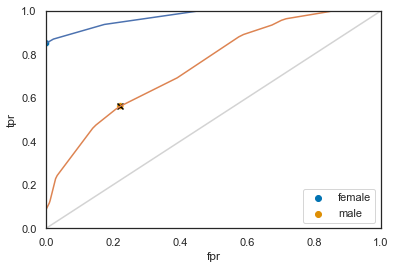

In [10]:
pb_roc.plot(lp_lines=False)

Using `.plot()` with `lp_lines` set to `True` will show the convex hulls corresponding to the thresholded predictions. Here, we'll drop the ROC curves to show the geometry of the solution more clearly.

opt coords  0.2217   0.5616


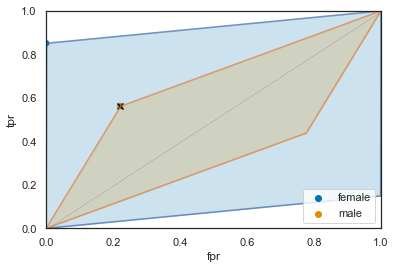

In [11]:
pb_roc.plot(roc_curves=False)